In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import struct
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [20]:
train_images_path = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
train_labels_path = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
test_images_path = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_path = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

# To load files in IDX format
def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [21]:
# Loading the data
X_train = load_idx(train_images_path)
y_train = load_idx(train_labels_path)
X_test = load_idx(test_images_path)
y_test = load_idx(test_labels_path)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


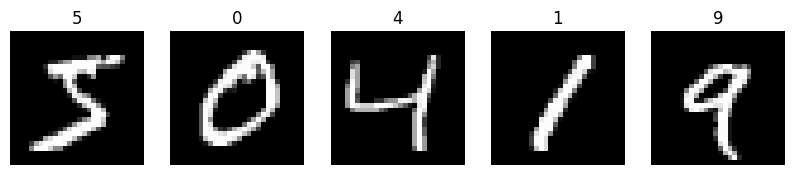

In [55]:
def plot_images(images, labels, num_images=5):
    # Create a figure for displaying images
    plt.figure(figsize=(10, 2))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        plt.imshow(images[i], cmap='gray')  # Display the image in grayscale
        plt.title(f'{labels[i]}')  # Set the title as the corresponding label
        plt.axis('off')  # Turn off the axis for a cleaner visualization
    plt.show()  # Show the plot with the selected images and labels
# Example: Plot 5 images and their corresponding labels    
plot_images(X_train, y_train, num_images=5)

In [24]:
# Flatten the images from 28x28 dimensions and normalize them
X_train_norm = X_train.reshape((X_train.shape[0], 28 * 28)).astype('float32') / 255
X_test_norm = X_test.reshape((X_test.shape[0], 28 * 28)).astype('float32') / 255

In [25]:
# Transpose the train and test sets, so now we have 784 rows and each column represents an example
X_train_norm = X_train_norm.T
X_test_norm = X_test_norm.T

In [26]:
print(X_train_norm.shape)
print(X_test_norm.shape)

(784, 60000)
(784, 10000)


In [27]:
def relu(Z1):
    return np.maximum(Z1, 0)

In [28]:
def softmax(Z2):
    return np.exp(Z2) / sum(np.exp(Z2))

In [29]:
def forward_prop(X, W1, B1, W2, B2):
    # X: ndarray (784, m) set of examples
    # W1: ndarray (10, 784)
    # B1: ndarray (10,)
    # W2: ndarray (10, 10)
    # B2: ndarray (10,)

    # (10, m) ndarray
    Z1 = W1.dot(X) + B1
    A1 = relu(Z1)
    # (10, m) ndarray
    Z2 = W2.dot(A1) + B2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [30]:
def deriv_relu(Z):
    return Z > 0

In [31]:
def one_hot(Y):
    # Y: ndarray (m, )
    
    m = Y.shape[0]
    Y_hot = np.zeros((m, Y.max()+1))
    Y_hot[np.arange(m), Y] = 1
    return Y_hot.T

In [32]:
def back_prop(X, Z1, A1, Z2, A2, W1, W2, Y):
    """
    y_hot = one_hot(Y)
    dl_dz2 = A2 - y_hot
    dl_dw2 = dl_dz2.dot(A1.T)
    dl_db2 = dl_dz2
    dl_da1 = W2.T.dot(dl_dz2)
    dl_dz1 = np.multiply(dl_da1, deriv_relu(Z1))
    dl_dw1 = dl_dz1.dot(X.T)
    dl_db1 = dl_dz1
    return dl_dw2, dl_db2, dl_dw1, dl_db1
    """
    m = X.shape[1]
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_relu(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

In [33]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions==Y) / Y.shape[0]

In [34]:
def descent(X, Y, W1, B1, W2, B2, alpha, iters):
    # X: ndarray (784, m)
    # Y: ndarray (m, )
    # W1: ndarray (10, 784)
    # B1: ndarray (10,)
    # W2: ndarray (10, 10)
    # B2: ndarray (10,)
    # alpha: float
    # iters: int

    step = iters // 10
    for i in range(iters):
        Z1, A1, Z2, A2 = forward_prop(X, W1, B1, W2, B2)
        dl_dw1, dl_db1, dl_dw2, dl_db2 = back_prop(X, Z1, A1, Z2, A2, W1, W2, Y)
        W1 = W1 - alpha * dl_dw1
        B1 = B1 - alpha * dl_db1
        W2 = W2 - alpha * dl_dw2
        B2 = B2 - alpha * dl_db2
        if i % step == 0 and (i // step) < 10:
            print("Iteration {}:".format(i))
            print("Accuracy: {}".format(get_accuracy(get_predictions(A2), Y)))
    return W1, B1, W2, B2

In [35]:
def generate_params():
    W1 = np.random.randn(10, 784)
    B1 = np.random.randn(10, 1)
    W2 = np.random.randn(10, 10)
    B2 = np.random.randn(10, 1)
    return W1, B1, W2, B2

In [36]:
W1, B1, W2, B2 = generate_params()
W1, B1, W2, B2 = descent(X_train_norm, y_train, W1, B1, W2, B2, 0.01, 10000)

Iteration 0:
Accuracy: 0.1081
Iteration 1000:
Accuracy: 0.48801666666666665
Iteration 2000:
Accuracy: 0.5553333333333333
Iteration 3000:
Accuracy: 0.60345
Iteration 4000:
Accuracy: 0.6395833333333333
Iteration 5000:
Accuracy: 0.66885
Iteration 6000:
Accuracy: 0.6926666666666667
Iteration 7000:
Accuracy: 0.7108833333333333
Iteration 8000:
Accuracy: 0.7259833333333333
Iteration 9000:
Accuracy: 0.7385333333333334


In [50]:
def apply_model(X, W1, B1, W2, B2):
    Z1, A1, Z2, A2 = forward_prop(X, W1, B1, W2, B2)
    predictions = get_predictions(A2)
    return predictions

In [53]:
indices = np.arange(20)
predictions = apply_model(X_test_norm[:, indices], W1, B1, W2, B2)
print(get_accuracy(predictions, y_test[indices]))

0.75


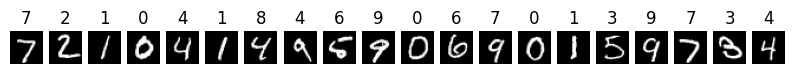

In [56]:
plot_images(X_test, predictions, num_images=predictions.size)